## ARIMA model - AutoRegressive Integrated Moving Average model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# Load Union City Area Price
df = pd.read_csv('../pre_data/UnionCity_price.csv')

In [3]:
data = df.set_index('date')
data.index = pd.DatetimeIndex(data.index)

In [4]:
data.head()

,price
date,
2010-11-01,1864.0
2010-12-01,1841.0
2011-01-01,1830.0
2011-02-01,1827.0
2011-03-01,1828.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 99 entries, 2010-11-01 to 2019-01-01
Data columns (total 1 columns):
price    99 non-null float64
dtypes: float64(1)
memory usage: 1.5 KB


In [6]:
# Select the best diff (Integrated)
from statsmodels.tsa.stattools import adfuller as ADF

print(ADF(data['price']))

(-2.0120639258516717, 0.2813086678556114, 5, 93, {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}, 635.4008789783361)


In [7]:
diff_1 = data.diff(1)
diff_1 = diff_1.dropna()
diff_1.columns = ['price_integrated']
print(ADF(diff_1['price_integrated']))

(-4.567937044602349, 0.00014793579673661353, 4, 93, {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}, 633.0191957422599)


In [8]:
from statsmodels.stats.diagnostic import acorr_ljungbox

noiseRes = acorr_ljungbox(diff_1, lags=1)
print(noiseRes)

(array([60.60740747]), array([6.96713439e-15]))


In [9]:
# Select the best AR(p) and MA(q)
from statsmodels.tsa.arima_model import ARMA

def proper_model(data, maxLag): 
    init_bic = float("inf")
    init_p = 0
    init_q = 0
    init_properModel = None
    for p in np.arange(maxLag):
        for q in np.arange(maxLag):
            model = ARMA(data, order=(p, q), freq='MS')
            try:
                results_ARMA = model.fit(disp=-1, method='css')
            except:
                continue
            bic = results_ARMA.bic
            if bic < init_bic:
                init_p = p
                init_q = q
                init_properModel = results_ARMA
                init_bic = bic
    return init_p, init_q

In [10]:
p,q = proper_model(data, 10)

/Users/ryne/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ryne/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ryne/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ryne/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ryne/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInv

In [11]:
print(p,q)

9 0


In [12]:
from statsmodels.tsa.arima_model import ARIMA

# Build ARIMA(9,1,0) model
model = ARIMA(data, (p,1,q), freq='MS')
arima_result = model.fit()

In [13]:
arima_result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 763.0942  
Dependent Variable: D.price          Log-Likelihood:      -356.33   
Date:               2019-03-28 15:20 Scale:               1.0000    
No. Observations:   98               Method:              css-mle   
Df Model:           10               Sample:              12-01-2010
Df Residuals:       88                                    01-01-2019
Converged:          1.0000           S.D. of innovations: 9.029     
No. Iterations:     26.0000          HQIC:                746.161   
AIC:                734.6595                                        
---------------------------------------------------------------------
                  Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const             2.3004    3.1048   0.7409  0.4607  -3.7849   8.3857
ar.L1.D.price     1.2164    0.0999  12.1807  0.0000   1.0206   1.4121
ar.L2.D.price    -0.2741    0.1561  -1.7559  0.0826  -0.5801   0.0319
ar.L3.D.price    -0.6652    0.1594  -4.1718  0.0001  -0.9777  -0.3527
ar.L4.D.price     0.8184    0.1698   4.8191  0.0000   0.4856   1.1513
ar.L5.D.price    -0.2348    0.1879  -1.2497  0.2147  -0.6031   0.1335
ar.L6.D.price    -0.3042    0.1697  -1.7931  0.0764  -0.6367   0.0283
ar.L7.D.price     0.0927    0.1579   0.5871  0.5586  -0.2168   0.4023
ar.L8.D.price     0.1800    0.1554   1.1586  0.2498  -0.1245   0.4845
ar.L9.D.price    -0.1247    0.0988  -1.2616  0.2104  -0.3183   0.0690
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1           -1.1296            -0.0000           1.1296            -0.5000
AR.2           -1.1898            -0.8904           1.4861            -0.3978
AR.3           -1.1898             0.8904           1.4861             0.3978
AR.4            0.2691            -1.0635           1.0971            -0.2106
AR.5            0.2691             1.0635           1.0971             0.2106
AR.6            1.1385            -0.3861           1.2022            -0.0520
AR.7            1.1385             0.3861           1.2022             0.0520
AR.8            1.0689            -0.8401           1.3596            -0.1060
AR.9            1.0689             0.8401           1.3596             0.1060
====================================================================

"""

In [14]:
# Get forecast 6 steps ahead in future
pred = arima_result.forecast(steps=6)

In [15]:
time = pd.date_range('20190201', periods=6, freq='MS')

In [16]:
pred_df = pd.DataFrame(np.round(pred[0],1), index = time, columns=['price'])

In [17]:
output = pd.concat([data, pred_df], axis=0)

In [18]:
output = output.reset_index()

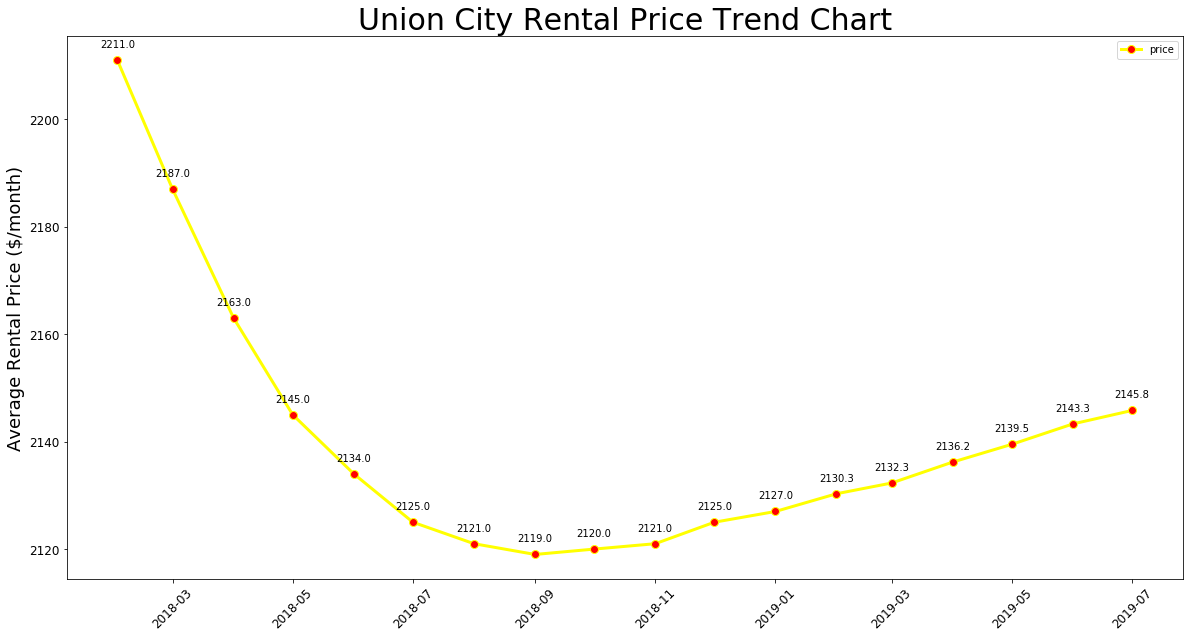

In [19]:
x = output['index'].tail(18)
y = output['price'].tail(18)

plt.figure(figsize = (20, 10))
plt.plot(x, y, linewidth = 3, color='yellow', marker = 'o', markerfacecolor='red', markersize=8)

plt.title('Union City Rental Price Trend Chart', fontsize = 30)
plt.ylabel('Average Rental Price ($/month)', fontsize = 18)
plt.tick_params(labelsize = 12)
plt.xticks(rotation = 45)
for i, j in zip(x, y):
    plt.text(i, j + 2, j, ha = 'center', va = 'bottom', fontsize = 10)
    
plt.legend()
plt.savefig("../area_predict_pics/UnionCity.jpg")
plt.show()

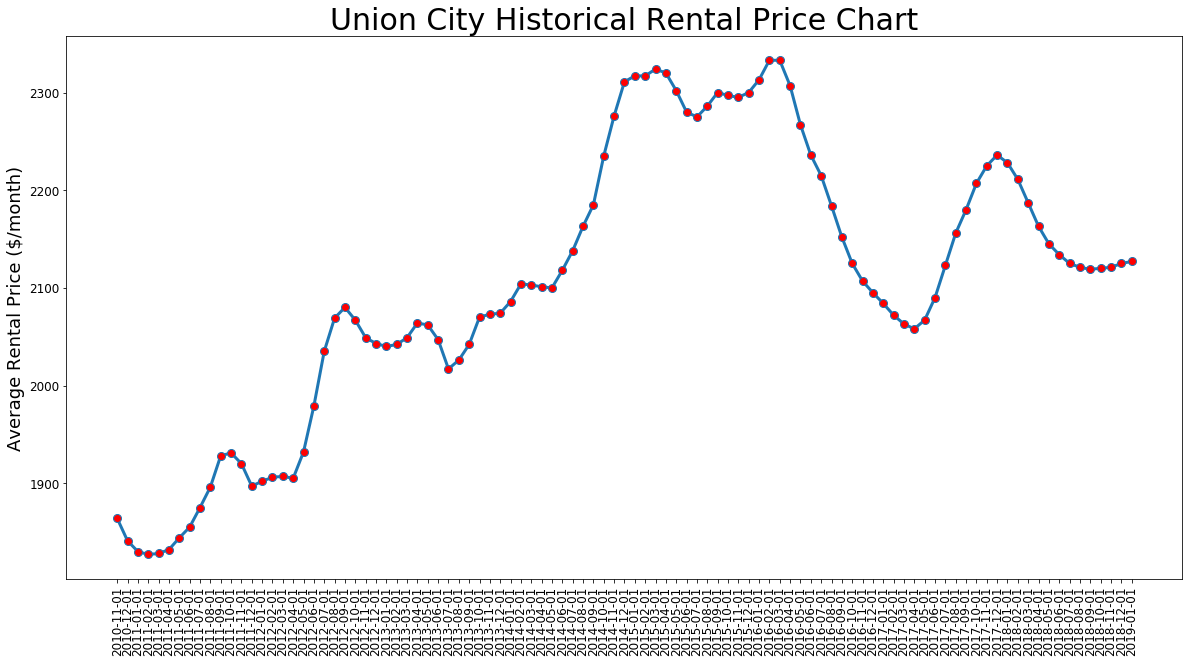

In [20]:
# Check the history data
m = df['date']
n = df['price']
plt.figure(figsize = (20, 10))
plt.plot(m, n, linewidth = 3, marker = 'o', markerfacecolor='red', markersize=8)
plt.title('Union City Historical Rental Price Chart', fontsize = 30)
plt.ylabel('Average Rental Price ($/month)', fontsize = 18)
plt.tick_params(labelsize = 12)
plt.xticks(rotation = 90)
# for i, j in zip(m, n):
#     plt.text(i, j + 2, j, ha = 'center', va = 'bottom', fontsize = 10)
plt.show()